In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import numpy as np
from IPython.display import Image
import qutip
from qutip import *
from tqdm import tqdm
from qutip.solver import correlation_2op_1t
from matplotlib import rc
from scipy.optimize import curve_fit
from scipy.linalg import expm
from scipy.fft import ifftshift
import scipy.signal as signal
from scipy.special import factorial
import matplotlib as mpl
from matplotlib import cm
from brokenaxes import brokenaxes  # Librería para ejes rotos
import pandas as pd
from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor
from optomechanics import *

In [2]:
#SYSTEM'S PARAMETERS
hbar=1
kappa= 250e-3 
g0 = np.logspace(-4, -1.8, 10) #For Omega=0.005 : np.logspace(-3, -0.75, 10), Omega=0.06 : np.logspace(-4, -1.8, 10)
Omega= 60e-3   # 0.005 eV= 0.02*kappa,  60e-3 
wm=100e-3
wc = 2.5 
gamma_m= 1e-3
n_th=0.02 # for T=300k
wl = wc
wlist=np.linspace(2, 3, 10000)
Delta= wc-wl
alpha= Omega/(kappa/2 + 1j*Delta) 
alpha2= alpha.conjugate()*alpha
g = g0*abs(alpha)

In [3]:
data = []

for i in range(len(g0)):
    Gamma_plus, Gamma_minus, Gamma_opt = Transition_rates(g0[i], alpha2, kappa, Delta, wm)
    nb = pop_phonons(gamma_m, Gamma_opt, n_th, Gamma_plus)
    S = [emission_spec(w, nb, Gamma_plus, Gamma_minus, Gamma_opt, gamma_m, wl, wm) for w in wlist]
    data.append({
        'g0': g0[i],
        'Δ': Delta,
        'Omega': Omega,
        'Gamma_plus': np.real(Gamma_plus),
        'Gamma_minus': np.real(Gamma_minus),
        'Gamma_opt': np.real(Gamma_opt),
        'Analytical S': np.real(S),
        'Analytical w': wlist,
        'C': g[i]**2/(kappa*gamma_m), 
        'g/k': g[i]/kappa
    })

df = pd.DataFrame(data)

In [4]:
df

,g0,Δ,Omega,Gamma_plus,Gamma_minus,Gamma_opt,Analytical S,Analytical w,C,g/k
0,0.000100,0.0,0.06,2.247805e-08,2.247805e-08,0.0,"[1.1564054246990052e-09, 1.157213670107664e-09...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.000009,0.000192
1,0.000176,0.0,0.06,6.928632e-08,6.928632e-08,0.0,"[3.564737430780791e-09, 3.5672289178384505e-09...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.000028,0.000337
2,0.000308,0.0,0.06,2.135681e-07,2.135681e-07,0.0,"[1.0990169398196557e-08, 1.0997850600421671e-0...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.000088,0.000592
3,0.000541,0.0,0.06,6.583022e-07,6.583022e-07,0.0,"[3.3897234225829046e-08, 3.3920924481360895e-0...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.000270,0.001039
4,0.000950,0.0,0.06,2.029150e-06,2.029150e-06,0.0,"[1.046857061323507e-07, 1.0475885934876685e-07...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.000832,0.001824
5,0.001668,0.0,0.06,6.254651e-06,6.254651e-06,0.0,"[3.2459190176166265e-07, 3.2481862804721755e-0...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.002564,0.003203
6,0.002929,0.0,0.06,1.927933e-05,1.927933e-05,0.0,"[1.0186573205264262e-06, 1.0193679521602437e-0...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.007905,0.005623
7,0.005142,0.0,0.06,5.942659e-05,5.942659e-05,0.0,"[3.31221719066754e-06, 3.314519476708636e-06, ...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.024365,0.009872
8,0.009027,0.0,0.06,1.831765e-04,1.831765e-04,0.0,"[1.1846712031735544e-05, 1.1854871167527841e-0...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.075102,0.017332
9,0.015849,0.0,0.06,5.646231e-04,5.646231e-04,0.0,"[5.2071030959238316e-05, 5.2106276357396615e-0...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.231495,0.030430


In [42]:
#NUMERICAL SIMULATION
#Hamiltonian construction
Nc = 12  # Number of cavity states
Nm = 10 # Number of mech states

a = tensor(destroy(N=Nc), qeye(Nm))
b = tensor(qeye(Nc), destroy(N=Nm))
num_b = b.dag() * b
num_a = a.dag() * a
#Choose Hamiltonian
H = [hbar*Delta*num_a+hbar*wm*num_b+1j*Omega*(a.dag()-a)-g*num_a*(b.dag()+b) for g in g0]
Hlin = [hbar*wm*num_b+hbar*Delta*num_a-hbar*abs(alpha)*g*(a.dag()+a)*(b.dag()+b) for g in g0]
c_ops = [np.sqrt(kappa)*a, np.sqrt((n_th+1)*gamma_m)*b, np.sqrt(n_th*gamma_m)*b.dag()]

In [43]:
%%time

tlist = np.linspace(0, 30000, 50000)

results1 = Parallel(n_jobs=8)(delayed(spectrum_calculation)(Hlin[i], tlist, wl, wm, c_ops, a, b) for i in tqdm(range(len(g0))))
for key in results1[0].keys():
    df[key] = [res[key] for res in results1]

100%|██████████| 10/10 [00:00<00:00, 156.82it/s]


CPU times: total: 2.62 s
Wall time: 7min 12s


In [44]:
df

,g0,Δ,Omega,Gamma_plus,Gamma_minus,Gamma_opt,Analytical S,Analytical w,C,g/k,...,wS1,wS2,wS3,wAS1,wAS2,FWHM_S1,FWHM_S2,FWHM_S3,FWHM_AS1,FWHM_AS2
0,0.000100,0.0,0.06,2.247805e-08,2.247805e-08,0.0,"[1.1564054246990052e-09, 1.157213670107664e-09...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.000009,0.000192,...,2.400099,2.299989,2.200089,2.599901,2.700011,0.001047,0.040840,0.071208,0.001047,0.014660
1,0.000176,0.0,0.06,6.928632e-08,6.928632e-08,0.0,"[3.564737430780791e-09, 3.5672289178384505e-09...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.000028,0.000337,...,2.400099,2.299989,2.200089,2.599901,2.700011,0.001047,0.052568,0.047542,0.001047,0.067229
2,0.000308,0.0,0.06,2.135681e-07,2.135681e-07,0.0,"[1.0990169398196557e-08, 1.0997850600421671e-0...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.000088,0.000592,...,2.400099,2.299989,2.200089,2.599901,2.700011,0.001047,0.084612,0.021153,0.001047,0.103670
3,0.000541,0.0,0.06,6.583022e-07,6.583022e-07,0.0,"[3.3897234225829046e-08, 3.3920924481360895e-0...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.000270,0.001039,...,2.400099,2.299989,2.200089,2.599901,2.700011,0.001047,0.098016,0.024085,0.001047,0.098853
4,0.000950,0.0,0.06,2.029150e-06,2.029150e-06,0.0,"[1.046857061323507e-07, 1.0475885934876685e-07...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.000832,0.001824,...,2.400099,2.299989,2.200089,2.599901,2.700011,0.001047,0.100738,0.094455,0.001047,0.096131
5,0.001668,0.0,0.06,6.254651e-06,6.254651e-06,0.0,"[3.2459190176166265e-07, 3.2481862804721755e-0...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.002564,0.003203,...,2.400099,2.299989,2.200089,2.599901,2.700011,0.001047,0.097597,0.028064,0.001047,0.050264
6,0.002929,0.0,0.06,1.927933e-05,1.927933e-05,0.0,"[1.0186573205264262e-06, 1.0193679521602437e-0...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.007905,0.005623,...,2.400099,2.299989,2.200089,2.599901,2.700011,0.001047,0.094036,0.099901,0.001047,0.099901
7,0.005142,0.0,0.06,5.942659e-05,5.942659e-05,0.0,"[3.31221719066754e-06, 3.314519476708636e-06, ...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.024365,0.009872,...,2.400099,2.299989,2.200089,2.599901,2.700011,0.001047,0.099272,0.080004,0.001047,0.099272
8,0.009027,0.0,0.06,1.831765e-04,1.831765e-04,0.0,"[1.1846712031735544e-05, 1.1854871167527841e-0...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.075102,0.017332,...,2.400099,2.299989,2.200089,2.599901,2.700011,0.001047,0.098853,0.080842,0.001047,0.090057
9,0.015849,0.0,0.06,5.646231e-04,5.646231e-04,0.0,"[5.2071030959238316e-05, 5.2106276357396615e-0...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.231495,0.030430,...,2.400099,2.299989,2.200089,2.599901,2.700011,0.001047,0.099901,0.089429,0.001047,0.099901


In [45]:
#REMEMBER TO CHANGE THE NAME !!!!!!!
#Name code: Omega_Hamiltonian
df.to_pickle("Results/Coupling_rate_results/06_lin.pkl")

In [3]:
df005=pd.read_pickle("Results/Coupling_rate_results/005_full.pkl") #Omega=0.005
df06=pd.read_pickle("Results/Coupling_rate_results/06_full.pkl") #Omega=0.06
df005lin=pd.read_pickle("Results/Coupling_rate_results/005_lin.pkl") #Omega=0.005
df06lin=pd.read_pickle("Results/Coupling_rate_results/06_lin.pkl") #Omega=0.06

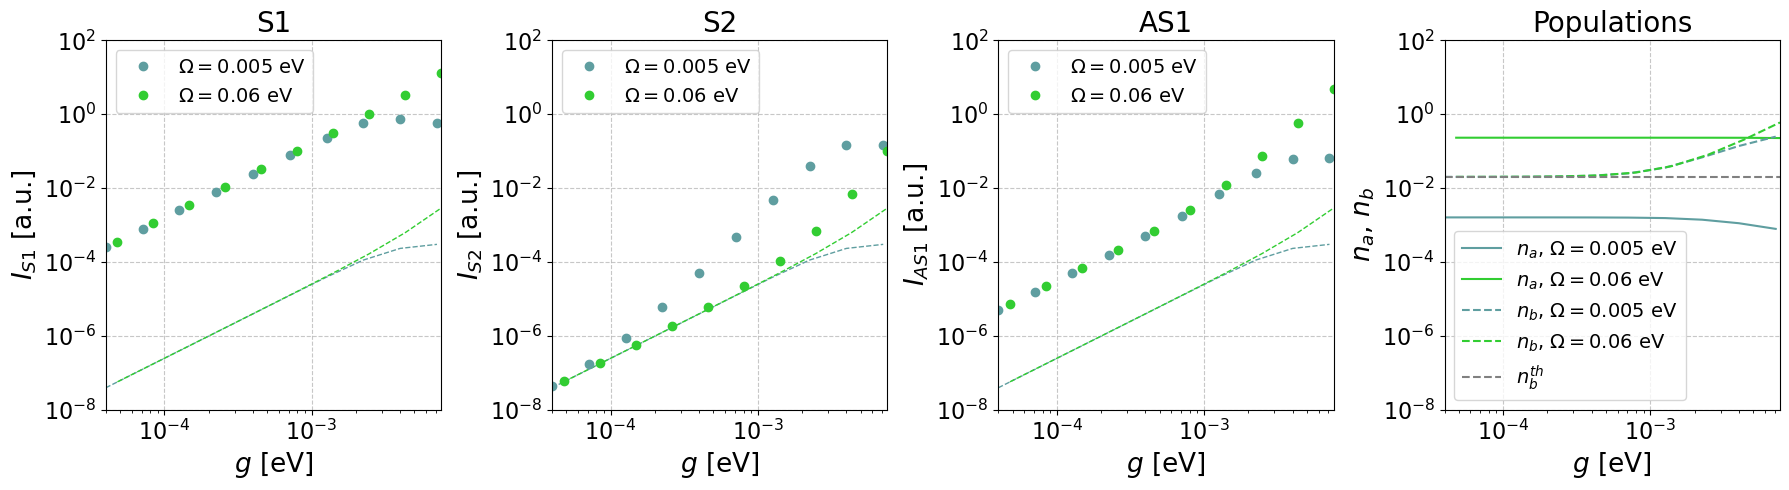

In [4]:
df1=df005
df2=df06
x_axis1=df1['g/k']*kappa #df1['g/k']*kappa
x_axis2=df2['g/k']*kappa #df2['g/k']*kappa
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

for i in range(3):
    axes[i].plot(x_axis1, df1['Noise Floor'], linestyle='--', color='cadetblue', linewidth=1)
    axes[i].plot(x_axis2, df2['Noise Floor'], linestyle='--', color='limegreen', linewidth=1)

#Omega=0.005
axes[0].plot(x_axis1, df1['S1'], 'o', label=r"$\Omega=$"+f'{df1['Omega'][0]} eV', color='cadetblue')
axes[1].plot(x_axis1, df1['S2'], 'o', label=r"$\Omega=$"+f'{df1['Omega'][0]} eV',  color='cadetblue')
axes[2].plot(x_axis1, df1['AS1'], 'o', label=r"$\Omega=$"+f'{df1['Omega'][0]} eV',  color='cadetblue')
#Omega=0.06
axes[0].plot(x_axis2, df2['S1'], 'o', label=r"$\Omega=$"+f'{df2['Omega'][0]} eV', color='limegreen')
axes[1].plot(x_axis2, df2['S2'], 'o', label=r"$\Omega=$"+f'{df2['Omega'][0]} eV', color='limegreen')
axes[2].plot(x_axis2, df2['AS1'], 'o', label=r"$\Omega=$"+f'{df2['Omega'][0]} eV', color='limegreen')
#Populations
axes[3].plot(df1['g/k']*kappa, df1['na'], label=r"$n_a$, $\Omega=$"+f'{df1['Omega'][0]} eV', color='cadetblue', markersize=4)
axes[3].plot(df2['g/k']*kappa, df2['na'], label=r"$n_a$, $\Omega=$"+f'{df2['Omega'][0]} eV', color='limegreen', markersize=4)
axes[3].plot(df1['g/k']*kappa, df1['nb'], linestyle='--', label=r"$n_b$, $\Omega=$"+f'{df1['Omega'][0]} eV', color='cadetblue', markersize=4)
axes[3].plot(df2['g/k']*kappa, df2['nb'], linestyle='--', label=r"$n_b$, $\Omega=$"+f'{df2['Omega'][0]} eV', color='limegreen', markersize=4)
axes[3].axhline(y=n_th, linestyle='--', color='grey', label=r'$n^{th}_b$')
#axes[3].text(10**(-2.4), 10**(-1.4), r'$n^{th}$', fontsize=14, color='black', va='center')

for i in range(4):
    axes[i].set_xlabel(r"$g$ [eV]", fontsize=19)
    axes[i].set_xlim(df1['g/k'][0]*kappa, df2['g/k'][9]*kappa) #(df2['g0'][0], df1['g0'][9]), (df1['g/k'][0], df2['g/k'][9]) 
    axes[i].set_ylim(1e-8, 1e2)
    axes[i].set_yscale('log')
    axes[i].set_xscale('log')
    axes[i].grid(True, linestyle='--', alpha=0.7)
    axes[i].tick_params(axis='both', labelsize=16)
axes[0].legend(loc='upper left', fontsize=14)
axes[1].legend(loc='upper left', fontsize=14)
axes[2].legend(loc='upper left', fontsize=14)
axes[3].legend(loc='lower left', fontsize=14)
axes[0].set_ylabel(r"$I_{S1}$ [a.u.]", fontsize=19)
axes[1].set_ylabel(r"$I_{S2}$ [a.u.]", fontsize=19)
axes[2].set_ylabel(r"$I_{AS1}$ [a.u.]", fontsize=19)
axes[0].set_title(r"S1", fontsize=20)
axes[1].set_title(r"S2", fontsize=20)
axes[2].set_title(r"AS1", fontsize=20)
axes[3].set_ylabel(r"$n_a$, $n_b$", fontsize=19)
axes[3].set_title(r"Populations", fontsize=20)

#REMEMBER CHANGING THE NAME !!!!!!!!
plt.tight_layout()
#plt.savefig("Results/Coupling_rate_results/full_signals_vs_g.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Fitting

In [29]:
def curve(g0, A, B):
    return  A * g0**B

def expected(g0, A):
    return  A * g0**2

In [94]:
df1=df005
df2=df06

x1=(df1['g/k']*kappa)
x2=(df2['g/k']*kappa)

y1s1=((df1['S1']-df1['S1'][0])/df1['S1'][0])[:6]
y1s2=((df1['S2']-df1['S2'][0])/df1['S2'][0])[:5]
y1as1=((df1['AS1']-df1['AS1'][0])/df1['AS1'][0])[:6]
y2s1=((df2['S1']-df2['S1'][0])/df2['S1'][0])[:6]
y2s2=((df2['S2']-df2['S2'][0])/df2['S2'][0])[:5]
y2as1=((df2['AS1']-df2['AS1'][0])/df2['AS1'][0])[:6]

line11, cov1 = curve_fit(curve, x1[:6], y1s1, p0=[1,1]) #p0=[2,1]
line21, cov2 = curve_fit(curve, x1[:5], y1s2, p0=[5.80723174e+08, 4])
line31, cov4 = curve_fit(curve, x1[:6], y1as1)

line12, cov1 = curve_fit(curve, x2[:6], y2s1, p0=[1,1]) #p0=[2,1]
line22, cov2 = curve_fit(curve, x2[:5], y2s2,  p0=[5.80723174e+08, 2])
line32, cov4 = curve_fit(curve, x2[:6], y2as1)
